# LCF Analysis

This example uses LCF to analayse a large time resolved XAS dataset

In absence of further data, the process is:
Make a list of the files in the dataset, assuming the naming is tied to the time when spectra was collected.
- Read the first spectra, T<sub>0</sub>
- Read the last spectra, T<sub>n</sub>
- Set T<sub>0</sub> as the first component of the LCF
- Set T<sub>n</sub> as the second component of the LCF
- Do a binary search for the spectra T<sub>x</sub> where:
  - the weight from T<sub>0</sub> is ≅100%, that is T<sub>n</sub> is the smallest it can be
  - the weight from T<sub>0</sub> ≅ T<sub>n</sub>, that is the contributions are close to 50/50
  - the weight from T<sub>n</sub> is ≅100%, that is T<sub>0</sub> is the smallest it can be

The binary search proceeds as follows:
1. Set the search range as \[0,n\]
2. Read the middle spectra T<sub>n/2</sub>
3. Do a LCF using T<sub>0</sub> and T<sub>n</sub>
4. Test and adjust search range:
    1. If searching for T<sub>0</sub> dominant:
        1. If the weight of T<sub>n</sub> is greather than 2%  set the range = \[n/2, n\] and repeat from 2.
        2. If the weight of T<sub>n</sub> is smaller than 2% set the range  = \[0, n/2\] and repeat from 2.
        3. Stop if range length <= 1 or weight T<sub>n</sub> less than 2 % and greather than 0 (no negatives)
    2. If searching for weight T<sub>0</sub> ≅ weight T<sub>n</sub>
        1. If the weight of T<sub>n</sub> is greather than the weight of T<sub>0</sub> set the search range  = \[0, n/2\] and repeat from 2.
        2. If the weight of T<sub>n</sub> is smaller than the weight of T<sub>0</sub> set the search range  = \[n/2, n\] and repeat from 2.
        3. stop if range length <= 1 
    3. If searching for T<sub>n</sub> dominant:
        1. If the weight of T<sub>0</sub> is smaller than 2% set the range  = \[n/2, n\] and repeat from 2.
        2. If the weight of T<sub>0</sub> is greather than 2%  set the range = \[0, n/2\] and repeat from 2.
        3. Stop if range length <= 1 or weight T<sub>0</sub> less than 2 % and greather than 0 (no negatives)


## Resources
Pyhon modules and libraries used in this example

In [1]:
# code for importing custom helper libraries
import sys

# working with zipped files
import zipfile

# moved all custom helper libraries to a level bellow this directory.
sys.path.append('../lib/')

# Library with the functions that provide the larch functionalities
# equivalent to those provided by athena including normalisation, 
# merging, re-binning, LCF and visualisation (plotting)
import manage_athena as athenamgr 

# library to read ascii files
# this should be in the athenamgr lib
from larch.io import read_ascii

# additional custom plot functions (replicate plots in published papers)
import custom_plots

# File handling
from pathlib import Path

# Handling json files
import json

# printing formated json data
import pprint

# to copy the mutable types like dictionaries, use copy/deepcopy 
import copy

#plotting library
import matplotlib.pyplot as plt
# inline: shows plot in notebook
# tk: shows plot in popup
%matplotlib inline 


## Custom processing functions

In [2]:

def get_file_list_zip(zip_file = "", show_info = False):
    files_list = []
    if Path(zip_file).is_file():
        zip_data = zipfile.ZipFile(zip_file)
        files_list = zip_data.namelist()
    if show_info:
        print ("The first file is ", files_list [0])
        print ("The last file is ", files_list [-1])
        print (f"There are: {len(files_list)} files in the zip file")
    return files_list

def xas_from_zip(zip_file="", zipped_file_name="", columns = ""):
    work_dir = "./wd_temp"
    tmp_file = Path(zipped_file_name).name
    a_data_group = None
    if Path(zip_file).is_file():
        zip_data = zipfile.ZipFile(zip_file)
        # extract a specific file from the zip container
        f = zip_data.open(zipped_file_name)

        # save the extraced file 
        content = f.read()
               
        working_file = Path(work_dir, tmp_file)
    
        working_file.parents[0].mkdir(parents=True, exist_ok=True)
        
        f = open(working_file, 'wb')
        f.write(content)
        f.close()
        
        a_data_group = read_ascii(working_file, columns)
        
    return a_data_group

# LCF plot
def lcf_plot(group1, group2, xlim=[29180, 29230], show_comps = False):
    plt.grid(color='lightgrey', linestyle=':', linewidth=1) #show and format grid
    plt.plot(group1.energy, group1.norm, label=group1.label, linewidth=4,color='blue')
    plt.plot(group2.energy, group2.mu, label=group2.filename, linewidth=2, color='orange',linestyle='--')
    if show_comps:
        for one_comp in group2.ycomps:
            plt.plot(group2.energy, group2.ycomps[one_comp], label=one_comp, linewidth=2, linestyle=':')
    plt.title(group2.arrayname, fontsize=8)
    plt.legend() # show legend 
    plt.xlim(xlim)

    return plt


def plot_lcf_components(lcf_comps, offsets = [-20,30]):
    for a_dg in lcf_comps:
        plt = athenamgr.plot_mu(lcf_comps[a_dg])  
        plt.title("Plot components (first and last groups)")
        plt.xlim(lcf_comps[a_dg].e0+offsets[0],lcf_comps[a_dg].e0+offsets[1])
        print(lcf_comps[a_dg].filename, "E0:", lcf_comps[a_dg].e0)
    plt.show()

def get_components(zip_file_path, files_list, column_headres = "energy mu"):
    first_dg = xas_from_zip(zip_file_path, files_list [0], columns = column_headres)
    first_dg.filename = 'first'
    last_dg = xas_from_zip(zip_file_path, files_list [-1], columns = column_headres)
    last_dg.filename = 'last'
    lcf_comps = {"first": first_dg, "last": last_dg}
    for a_dg in lcf_comps:
        lcf_comps[a_dg] = athenamgr.calc_with_defaults(lcf_comps[a_dg])
    return lcf_comps

# test for even split of components:
def evenly_split(wgt_first, wgt_last, lower_v, higher_v, mid_v):
    # this condition finds the point closer to 50/50 split
    if wgt_first > wgt_last:
        lower_v = mid_v
    else:
        higher_v = mid_v
    return lower_v, higher_v

# test for the second component 
def higher_dominates(wgt_first, wgt_last, lower_v, higher_v, mid_v):
    if wgt_first >  0.02:
        lower_v = mid_v    
    else:
        higher_v = mid_v  
    return lower_v, higher_v

# test for the first component
def lower_dominates(wgt_first, wgt_last, lower_v, higher_v, mid_v):
    if wgt_last >  0.02:
        higher_v = mid_v     
    else:
        lower_v = mid_v
    return lower_v, higher_v



#test_even   1  # if looking for the place where the two signals are ~50/50
#test_lower  2  # if looking for the spectra where lower is ~ 100 % 
#test_higher 3  # if looking for the spectra where higher is ~ 100 % 
def find_lcf_match(path_to_zip = "", variables= {}, w_test=0):
    
    files_list = get_file_list_zip(path_to_zip, True)
    lcf_components = get_components(path_to_zip, files_list, "energy mu")
    plot_lcf_components(lcf_components)

    # set L and R
    lower_val = 0 
    higher_val = len(files_list)-1

    min_lim = lcf_components[variables['reference_standard']].e0+ variables['lower_limit']
    max_lim = lcf_components[variables['reference_standard']].e0+ variables['upper_limit']

    tested = {}
    while higher_val > lower_val:
        mid_val = int(lower_val + (higher_val - lower_val) / 2)
        print(files_list[mid_val])
        test_dg = xas_from_zip(path_to_zip, files_list[mid_val], columns = "energy mu")
        test_dg = athenamgr.calc_with_defaults(test_dg)
        test_dg.label = variables['prefix'] + "{:05d}".format(mid_val)
        test_dg.filename = test_dg.label
        print(test_dg.e0)
        # do lcf of test group
        lcf_result = athenamgr.lcf_group(test_dg, 
                                         list(lcf_components.values()), 
                                         fit_limits=[min_lim, max_lim])
        weight_first = lcf_result.weights["first"] 
        weight_last = lcf_result.weights["last"] 
        print (lcf_result.weights)
        tested[mid_val] = [test_dg, lcf_result] 
        plt = lcf_plot(test_dg, lcf_result,[min_lim, max_lim],True)
        print("Goodness of LCF fit")
        print (test_dg.filename + " R Factor:\t", "%.4f" % lcf_result.rfactor)
        plt.show()
        if w_test == 1:
            lower_val, higher_val = evenly_split(weight_first, weight_last, lower_val, higher_val, mid_val)
            if abs(lower_val - higher_val) == 1:
                break
        elif w_test == 2:
            lower_val, higher_val = higher_dominates(weight_first, weight_last, lower_val, higher_val, mid_val)      
            if abs(lower_val - higher_val) == 1 or (weight_first <  0.001 and weight_first > 0):
                break
        elif w_test == 3:
            lower_val, higher_val = lower_dominates(weight_first, weight_last, lower_val, higher_val, mid_val) 
            if abs(lower_val - higher_val) == 1 or (weight_last <  0.001 and weight_last >  0.0):
                break
        else:
            print("No test selectected")
            break
    print("*"*90)
    return tested


In [3]:
# zip file containign normalised mu for the experiment
rh4co = Path("../wf_data/non_pub", "37119_Rh_4_CO_Oxidation_53_second_ascii.zip")
rh4co = Path("../wf_data/non_pub", "37123_Rh_4_CO_Oxidation_45_7_ascii.zip") 

# parameters for lcf 
task_lcf = {'name': 'lcf',
            'sequence': 1,
            'variables': {'lcf_components': ['first', 'last'],
                          'reference_standard': 'first',
                          'lower_limit': -20,
                          'upper_limit': 30,
                          'prefix':"rh4co_ox_"}}

The first file is  37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_00000.dat
The last file is  37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_03999.dat
There are: 4000 files in the zip file
first E0: 23225.067
last E0: 23224.387


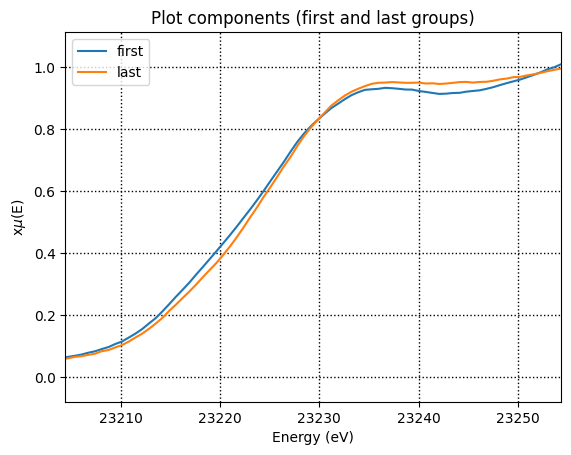

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01999.dat
23224.387
OrderedDict([('first', 0.31450814657501264), ('last', 0.6854918581115239)])
Goodness of LCF fit
rh4co_ox_01999 R Factor:	 0.0000


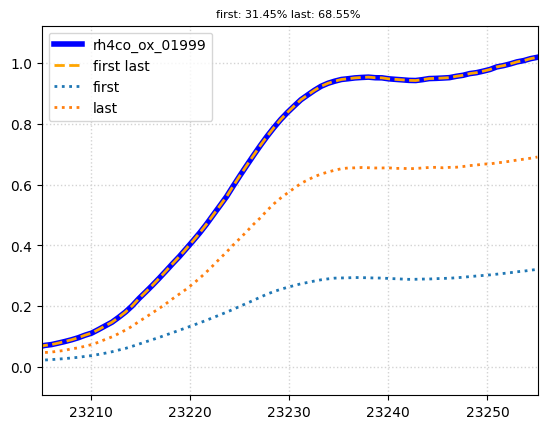

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_00999.dat
23225.067
OrderedDict([('first', 1.031759714730591), ('last', -0.031759699356173066)])
Goodness of LCF fit
rh4co_ox_00999 R Factor:	 0.0000


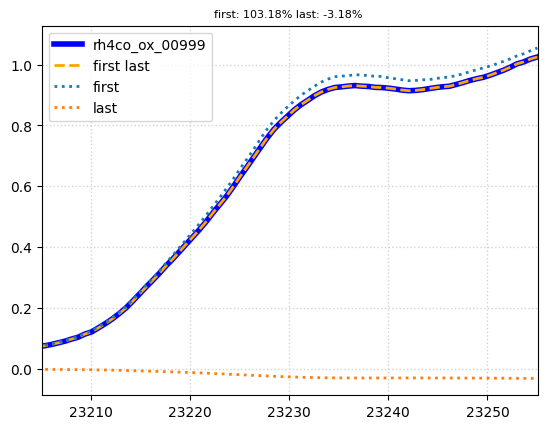

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01499.dat
23225.067
OrderedDict([('first', 0.9977043142796493), ('last', 0.0022957005873035508)])
Goodness of LCF fit
rh4co_ox_01499 R Factor:	 0.0000


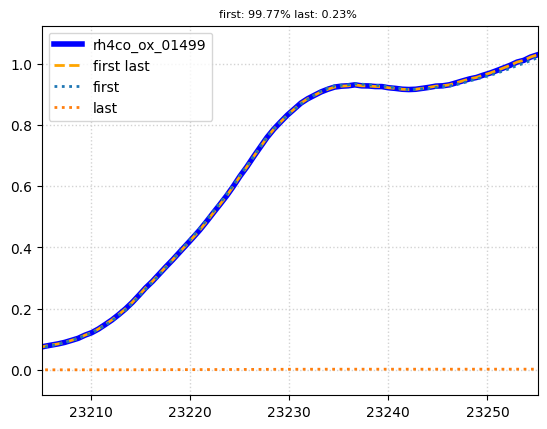

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01749.dat
23225.067
OrderedDict([('first', 0.5129252148065349), ('last', 0.48707479283664645)])
Goodness of LCF fit
rh4co_ox_01749 R Factor:	 0.0000


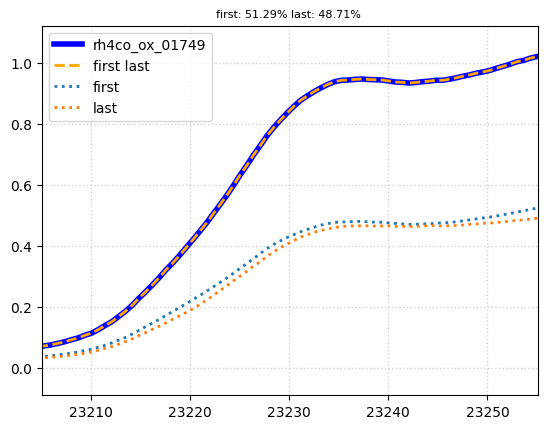

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01874.dat
23225.067
OrderedDict([('first', 0.5183798334079608), ('last', 0.4816201743165007)])
Goodness of LCF fit
rh4co_ox_01874 R Factor:	 0.0000


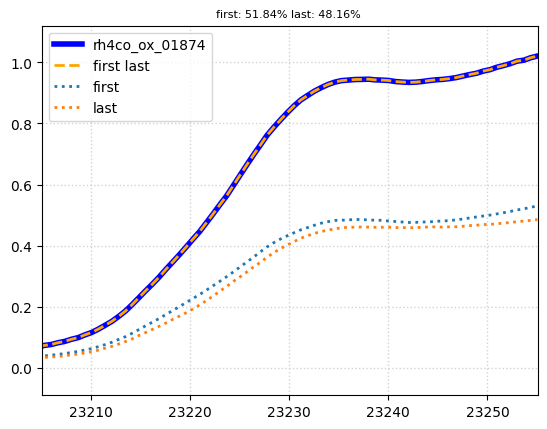

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01936.dat
23225.067
OrderedDict([('first', 0.4483305812208629), ('last', 0.5516694254597834)])
Goodness of LCF fit
rh4co_ox_01936 R Factor:	 0.0000


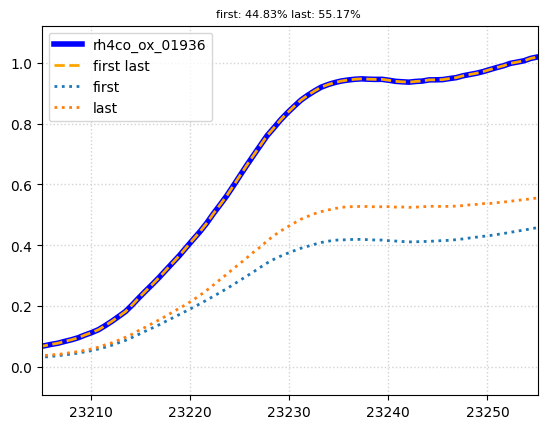

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01905.dat
23225.067
OrderedDict([('first', 0.33485949905991447), ('last', 0.6651405059298809)])
Goodness of LCF fit
rh4co_ox_01905 R Factor:	 0.0000


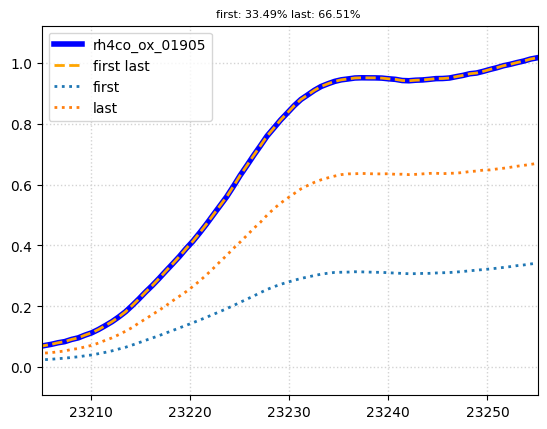

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01889.dat
23225.067
OrderedDict([('first', 0.34792405217926664), ('last', 0.6520759530052057)])
Goodness of LCF fit
rh4co_ox_01889 R Factor:	 0.0000


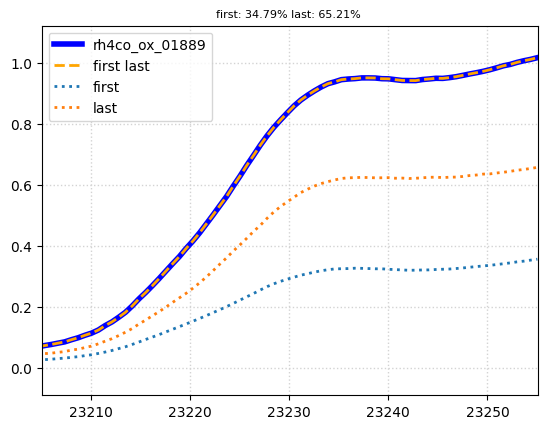

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01881.dat
23225.067
OrderedDict([('first', 0.4097396539295282), ('last', 0.5902603521760684)])
Goodness of LCF fit
rh4co_ox_01881 R Factor:	 0.0000


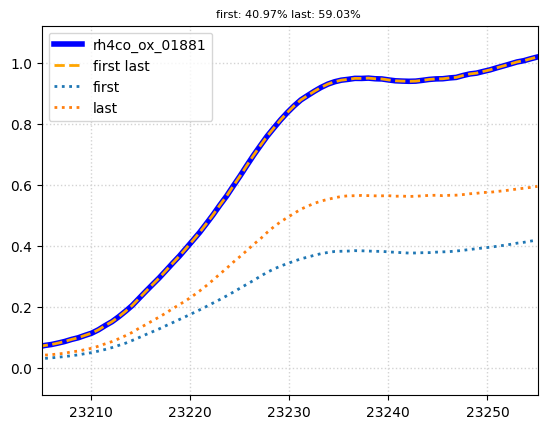

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01877.dat
23225.067
OrderedDict([('first', 0.4718855495973678), ('last', 0.5281144574342749)])
Goodness of LCF fit
rh4co_ox_01877 R Factor:	 0.0000


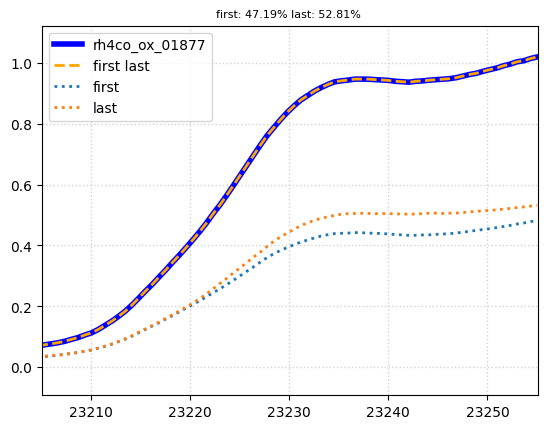

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01875.dat
23225.067
OrderedDict([('first', 0.4964490053972048), ('last', 0.5035510020004619)])
Goodness of LCF fit
rh4co_ox_01875 R Factor:	 0.0000


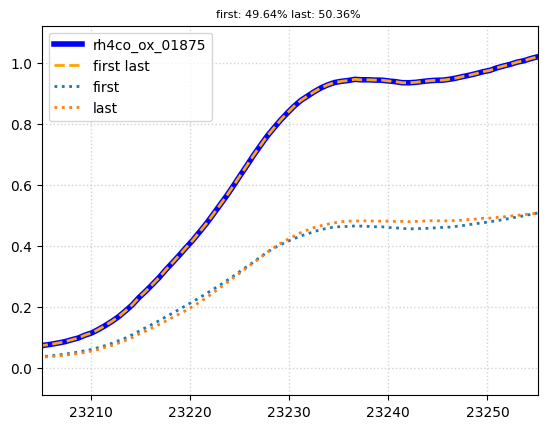

******************************************************************************************


In [4]:
# look for 50/50 split 

search_1 = find_lcf_match(rh4co, task_lcf['variables'], w_test=1)

In [5]:
search_1[list(search_1.keys())[-1]][1].result

The first file is  37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_00000.dat
The last file is  37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_03999.dat
There are: 4000 files in the zip file
first E0: 23225.067
last E0: 23224.387


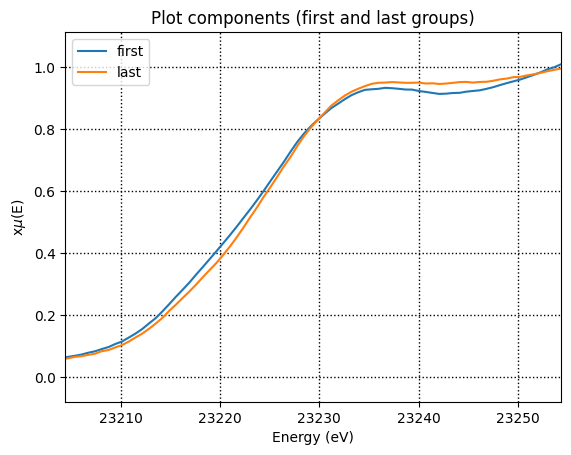

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01999.dat
23224.387
OrderedDict([('first', 0.31450814657501264), ('last', 0.6854918581115239)])
Goodness of LCF fit
rh4co_ox_01999 R Factor:	 0.0000


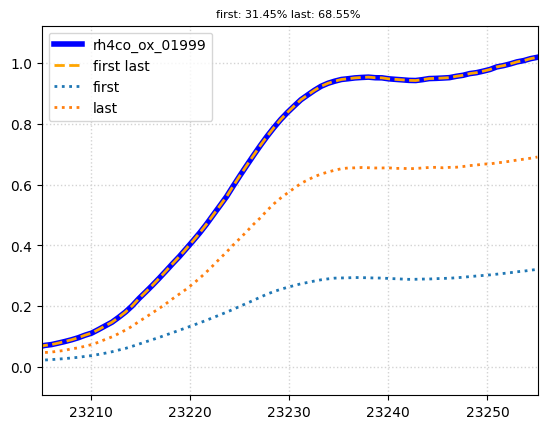

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_02999.dat
23224.387
OrderedDict([('first', 0.05081020118298611), ('last', 0.9491897995741448)])
Goodness of LCF fit
rh4co_ox_02999 R Factor:	 0.0000


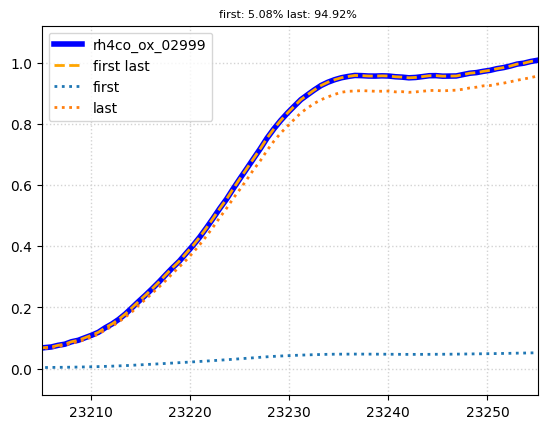

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_03499.dat
23225.067
OrderedDict([('first', 0.03128645660087476), ('last', 0.9687135438653298)])
Goodness of LCF fit
rh4co_ox_03499 R Factor:	 0.0000


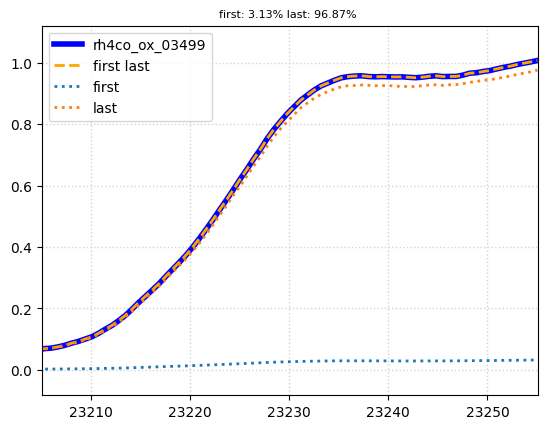

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_03749.dat
23225.748
OrderedDict([('first', 0.00388497615288963), ('last', 0.9961150239050011)])
Goodness of LCF fit
rh4co_ox_03749 R Factor:	 0.0000


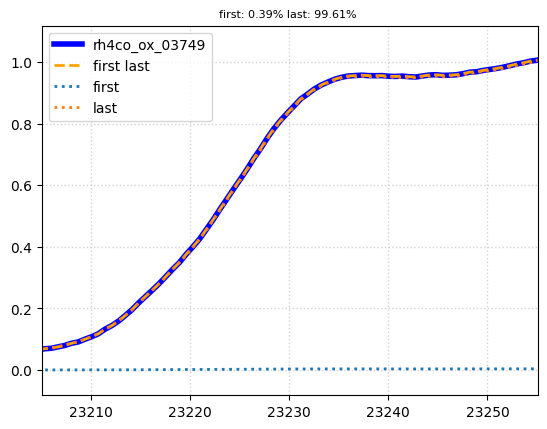

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_03624.dat
23224.387
OrderedDict([('first', 0.024913240682541415), ('last', 0.9750867596886948)])
Goodness of LCF fit
rh4co_ox_03624 R Factor:	 0.0000


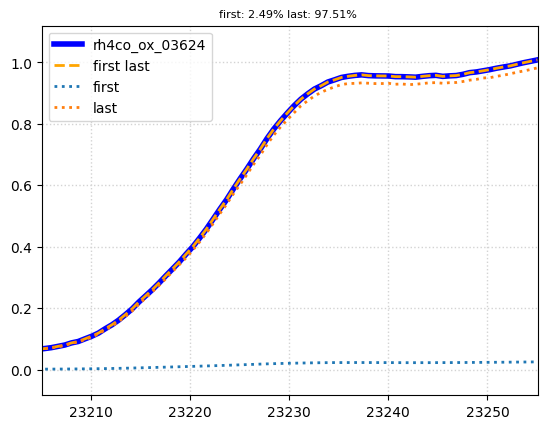

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_03686.dat
23224.387
OrderedDict([('first', 0.020493377786810374), ('last', 0.9795066225185648)])
Goodness of LCF fit
rh4co_ox_03686 R Factor:	 0.0000


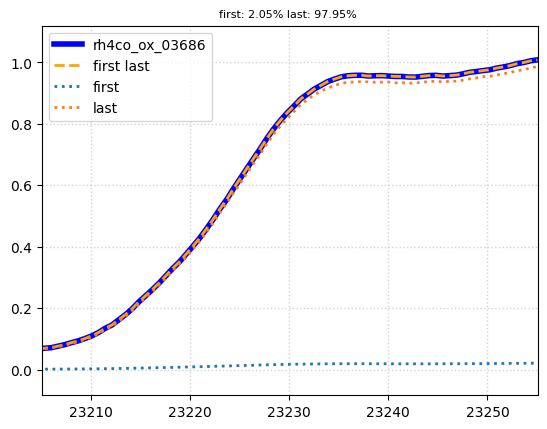

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_03717.dat
23224.387
OrderedDict([('first', 0.013827613687783452), ('last', 0.986172386518264)])
Goodness of LCF fit
rh4co_ox_03717 R Factor:	 0.0000


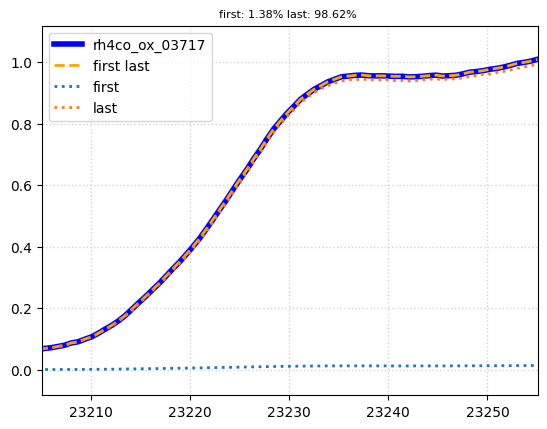

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_03701.dat
23225.067
OrderedDict([('first', 0.024603997304886327), ('last', 0.9753960030617418)])
Goodness of LCF fit
rh4co_ox_03701 R Factor:	 0.0000


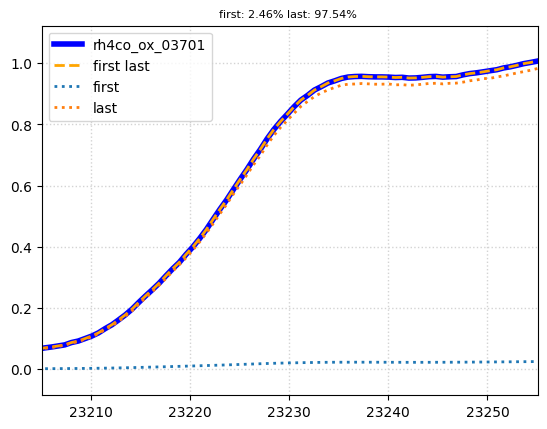

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_03709.dat
23225.067
OrderedDict([('first', 0.02534496654315604), ('last', 0.9746550338345134)])
Goodness of LCF fit
rh4co_ox_03709 R Factor:	 0.0000


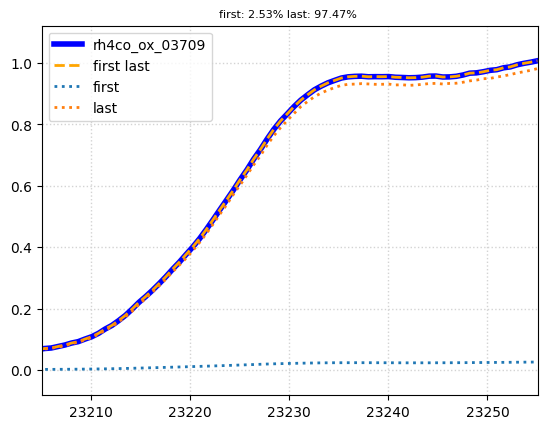

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_03713.dat
23225.067
OrderedDict([('first', 0.02505833457884383), ('last', 0.9749416657945544)])
Goodness of LCF fit
rh4co_ox_03713 R Factor:	 0.0000


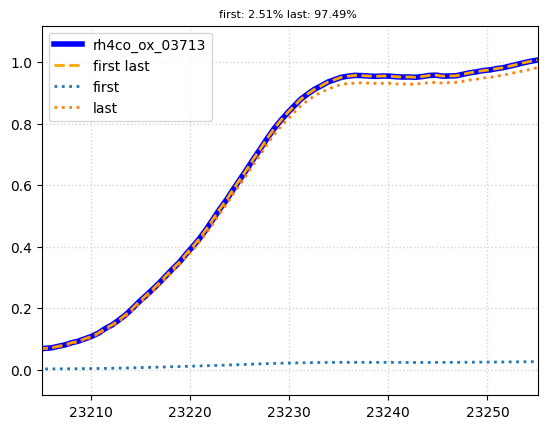

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_03715.dat
23225.067
OrderedDict([('first', 0.0339235333286877), ('last', 0.9660764671768123)])
Goodness of LCF fit
rh4co_ox_03715 R Factor:	 0.0000


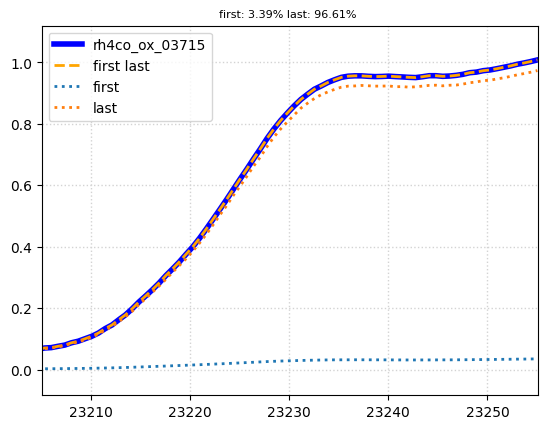

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_03716.dat
23225.067
OrderedDict([('first', 0.020664928600791777), ('last', 0.9793350717071396)])
Goodness of LCF fit
rh4co_ox_03716 R Factor:	 0.0000


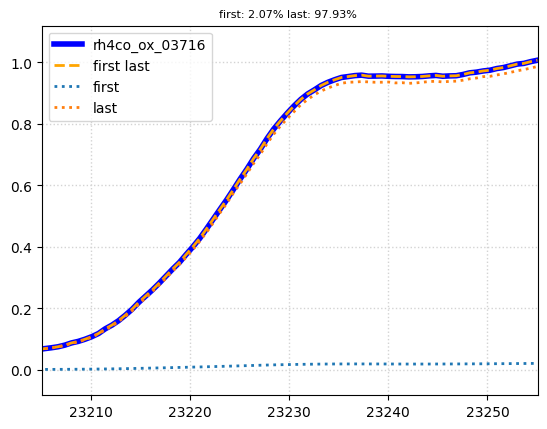

******************************************************************************************


In [6]:
# look for a combination where last is dominant 
search_2 = find_lcf_match(rh4co, task_lcf['variables'], w_test=2)

In [7]:
search_2[list(search_2.keys())[-1]][1].result

The first file is  37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_00000.dat
The last file is  37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_03999.dat
There are: 4000 files in the zip file
first E0: 23225.067
last E0: 23224.387


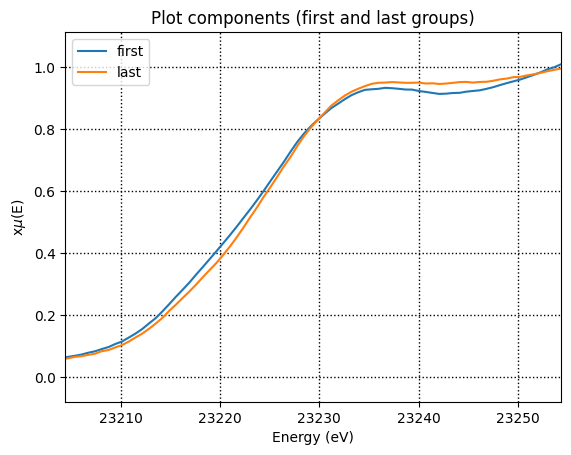

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01999.dat
23224.387
OrderedDict([('first', 0.31450814657501264), ('last', 0.6854918581115239)])
Goodness of LCF fit
rh4co_ox_01999 R Factor:	 0.0000


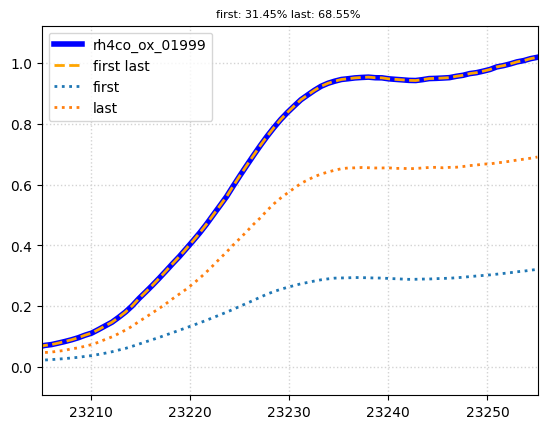

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_00999.dat
23225.067
OrderedDict([('first', 1.031759714730591), ('last', -0.031759699356173066)])
Goodness of LCF fit
rh4co_ox_00999 R Factor:	 0.0000


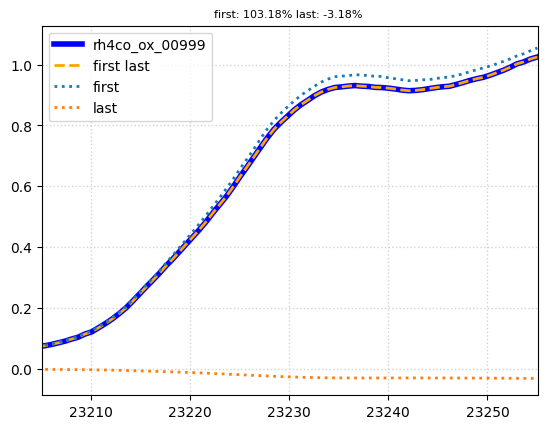

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01499.dat
23225.067
OrderedDict([('first', 0.9977043142796493), ('last', 0.0022957005873035508)])
Goodness of LCF fit
rh4co_ox_01499 R Factor:	 0.0000


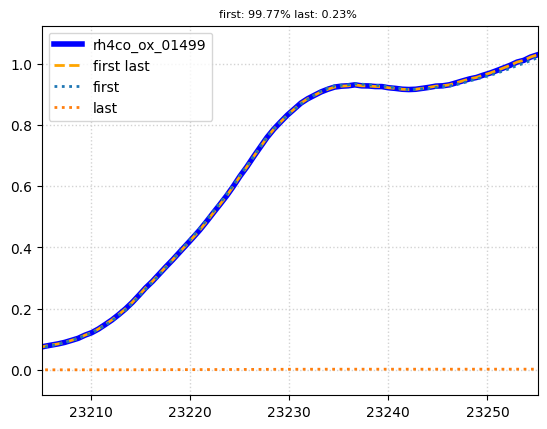

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01749.dat
23225.067
OrderedDict([('first', 0.5129252148065349), ('last', 0.48707479283664645)])
Goodness of LCF fit
rh4co_ox_01749 R Factor:	 0.0000


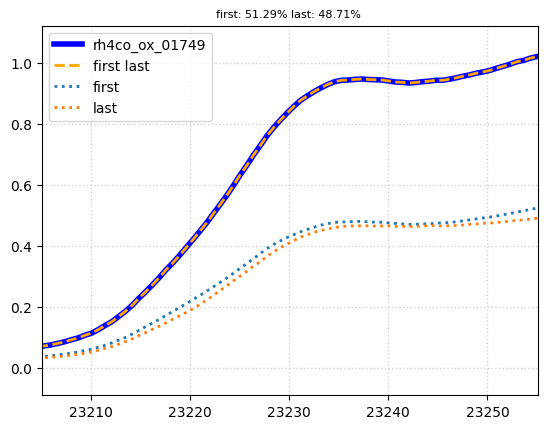

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01624.dat
23225.067
OrderedDict([('first', 0.9477931074523607), ('last', 0.052206906670857256)])
Goodness of LCF fit
rh4co_ox_01624 R Factor:	 0.0000


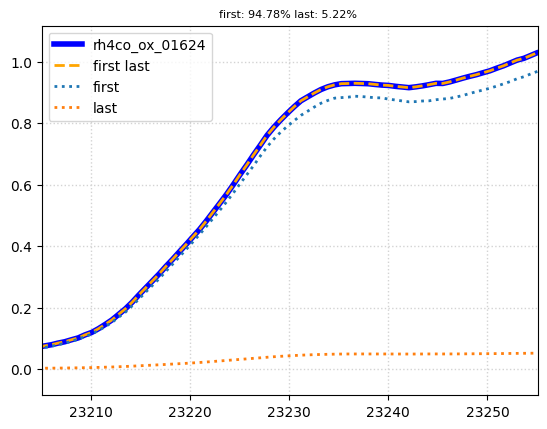

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01561.dat
23225.067
OrderedDict([('first', 0.9706922172146172), ('last', 0.02930779724982402)])
Goodness of LCF fit
rh4co_ox_01561 R Factor:	 0.0000


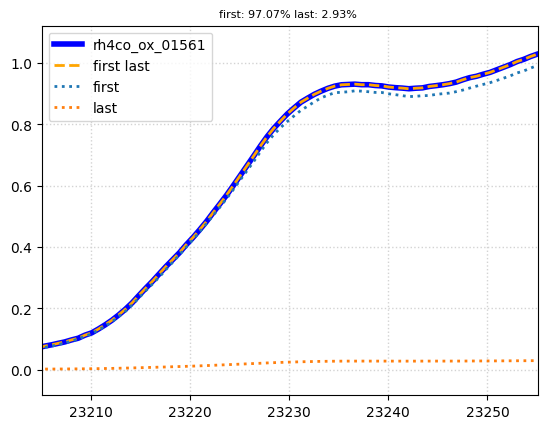

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01530.dat
23225.067
OrderedDict([('first', 0.9699841780068037), ('last', 0.03001583644708683)])
Goodness of LCF fit
rh4co_ox_01530 R Factor:	 0.0000


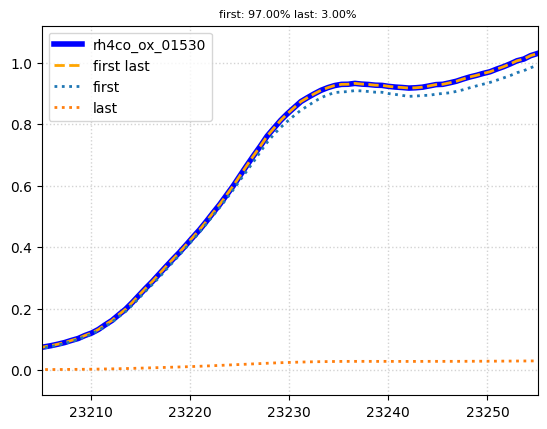

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01514.dat
23225.067
OrderedDict([('first', 0.9837837251249923), ('last', 0.016216289534527584)])
Goodness of LCF fit
rh4co_ox_01514 R Factor:	 0.0000


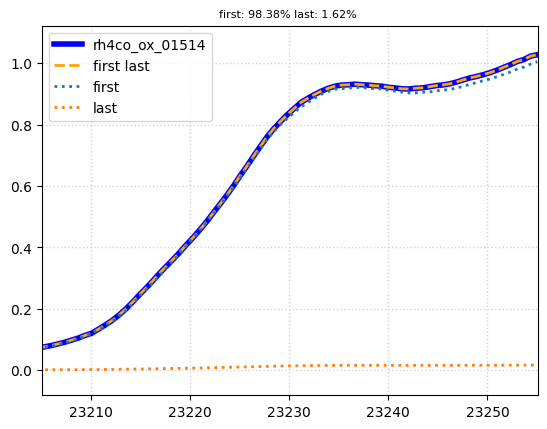

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01522.dat
23225.067
OrderedDict([('first', 0.9930792889978635), ('last', 0.0069207258001711125)])
Goodness of LCF fit
rh4co_ox_01522 R Factor:	 0.0000


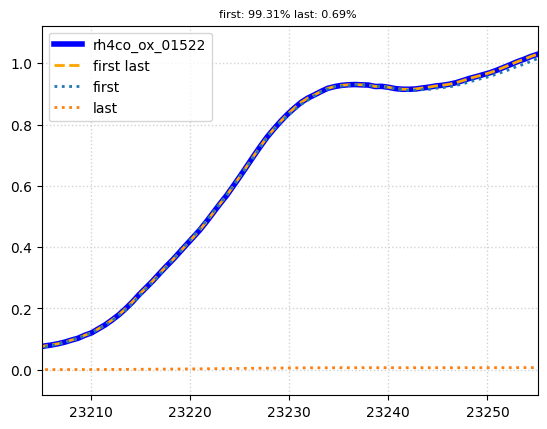

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01526.dat
23225.067
OrderedDict([('first', 0.9820584457163891), ('last', 0.017941568917422157)])
Goodness of LCF fit
rh4co_ox_01526 R Factor:	 0.0000


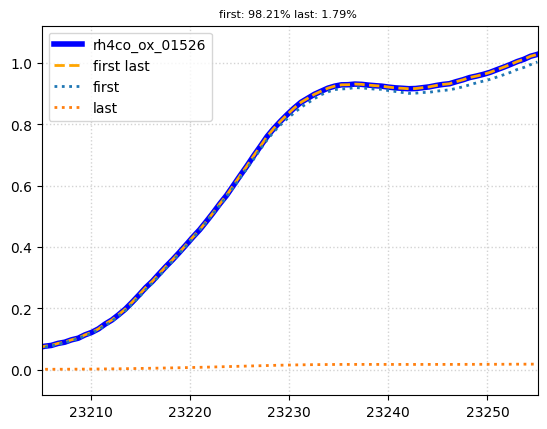

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01528.dat
23225.067
OrderedDict([('first', 0.9862507918517172), ('last', 0.013749222844564812)])
Goodness of LCF fit
rh4co_ox_01528 R Factor:	 0.0000


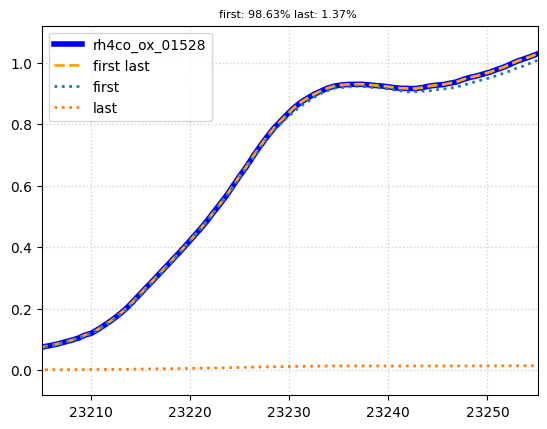

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01529.dat
23225.067
OrderedDict([('first', 0.9755335650339525), ('last', 0.024466449502630327)])
Goodness of LCF fit
rh4co_ox_01529 R Factor:	 0.0000


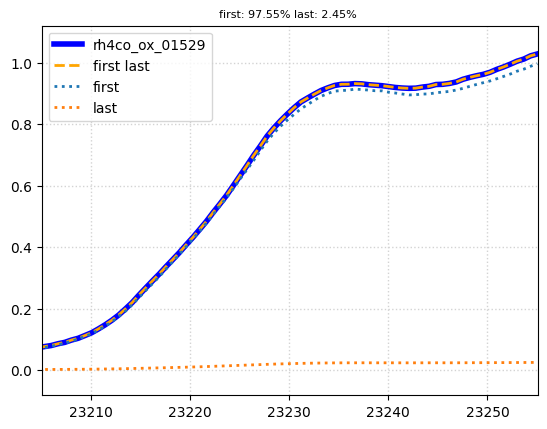

******************************************************************************************


In [8]:
# look for a combination where first is dominant 
search_3 = find_lcf_match(rh4co, task_lcf['variables'], w_test=3)

In [9]:
search_3[list(search_3.keys())[-1]][1].result

rh4co_ox_01529 (first dominant) E0: 23225.067
rh4co_ox_01875 (50/50) 		E0: 23225.067
rh4co_ox_03716 (last dominant) 	E0: 23225.067


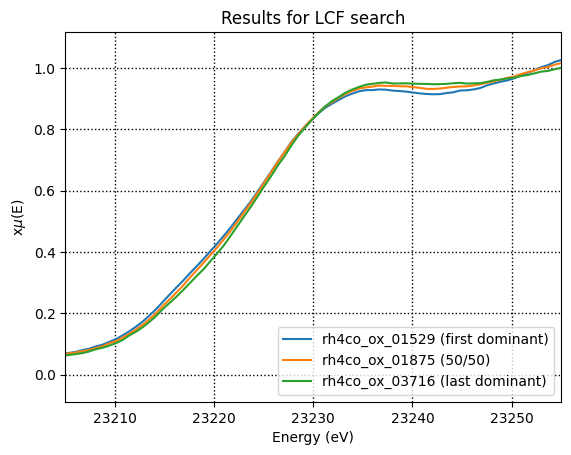

In [10]:
# plot the three results together
res_01 = search_1[list(search_1.keys())[-1]]
res_01[0].filename = res_01[0].label + " (50/50)"
res_02 = search_2[list(search_2.keys())[-1]]
res_02[0].filename = res_02[0].label + " (last dominant)"
res_03 = search_3[list(search_3.keys())[-1]]
res_03[0].filename = res_03[0].label + " (first dominant)"
plt = athenamgr.plot_mu(res_03[0])
plt = athenamgr.plot_mu(res_01[0])  
plt.xlim(round(res_01[1].xmin),round(res_01[1].xmax))
plt = athenamgr.plot_mu(res_02[0])

plt.title("Results for LCF search")

print(res_03[0].filename, "E0:", res_03[0].e0)
print(res_01[0].filename, "\t\tE0:", res_01[0].e0)
print(res_02[0].filename, "\tE0:", res_02[0].e0)


<Figure size 1800x300 with 0 Axes>

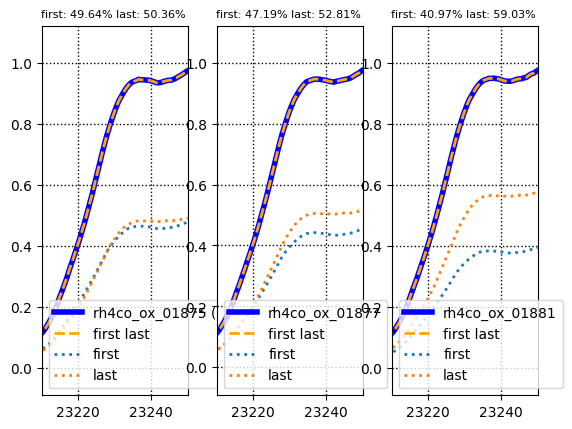

In [11]:
import importlib
importlib.reload(custom_plots)
plt = custom_plots.compare_3_lcf_plot(list(search_1.values()),[23210, 23250], True)
plt.show()